<a href="https://colab.research.google.com/github/Machine-Learning-Tokyo/ELSI-DL-Bootcamp/blob/master/kaggle_sat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle DeepSat SAT-6 example

This notebook is a simple example of how to approach the [DeepSat dataset](https://www.kaggle.com/crawford/deepsat-sat6)

## Data

The first thing we should do is to get the dataset.
The dataset is hosted at Kaggle, thus we can use the kaggle API to get the zip file.

The next cell installs the kaggle API

In [0]:
!pip install -U -q kaggle
!mkdir -p .kaggle
!mkdir -p ~/.kaggle

     |████████████████████████████████| 61kB 27.5MB/s 


Now we will use the API to get the data.

In order to do so we need a valid username and key (see [here](https://www.kaggle.com/docs/api) under Authentication).

In [0]:
%%capture
import json
token = {"username":"your name","key":"your key"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

After the authentication of our account we can download and unzip the data

In [0]:
!kaggle datasets download -d crawford/deepsat-sat6 -p /content  # download
!unzip deepsat-sat6.zip && rm deepsat-sat6.zip  # unzip and delete .zip file
!rm sat-6-full.mat  # deletes the .mat file (useful in case of Matlab)
!ls  # show the content of the currenct directory (we will use the *.csv files)

100% 2.42G/2.42G [00:44<00:00, 83.7MB/s]
100% 2.42G/2.42G [00:44<00:00, 58.0MB/s]
Archive:  deepsat-sat6.zip
  inflating: X_test_sat6.csv         
  inflating: sat6annotations.csv     
  inflating: X_train_sat6.csv        
  inflating: sat-6-full.mat          
  inflating: y_train_sat6.csv        
  inflating: y_test_sat6.csv         
sample_data	     sat-6-full.mat   X_train_sat6.csv	y_train_sat6.csv
sat6annotations.csv  X_test_sat6.csv  y_test_sat6.csv


## Helper Functions


Now that we have downloaded the data, let's define some functions to access them easily. Firstly, we will import some usefull packages:

- csv and pandas to read the .csv files
- numpy to process the numerical data
- pyplot to plot some images samples

In [0]:
import csv
import pandas as pd
import numpy as np
from numpy.random import randint, random, normal
import matplotlib.pyplot as plt

If you try to load the whole dataset (train and test) the kernel will crush since the available RAM is not big enough.

In [0]:
## this will crush!

# x_train = pd.read_csv('X_train_sat6.csv', header=None)
# y_train = pd.read_csv('y_train_sat6.csv', header=None)

# x_test = pd.read_csv('X_test_sat6.csv', header=None)
# y_test = pd.read_csv('y_test_sat6.csv', header=None)

Thus we have to follow another approach.

In the next cell we define some hyperparameters:
- EPOCHS: the number of epochs our Neural Network will be trained for. Each epoch is one pass through the whole dataset
- BATCH_SIZE: how many images will the network process at each iteration
- IMG_SHAPE: the dimensions of the images. Based on the description the images are 28x28 pixels and have 4 color channels
- TRAIN_NUM, TEST_NUM: the number of training and test images
- train_steps, test_steps: the number of iterations to complete one epoch

In [0]:
EPOCHS = 10
BATCH_SIZE = 64
IMG_SHAPE = 28, 28, 4

TRAIN_NUM, TEST_NUM = 324000, 81000  # from the dataset site
train_steps, test_steps = TRAIN_NUM // BATCH_SIZE, TEST_NUM // BATCH_SIZE


Since we cannot load the whole dataset to the memory we will read the files line by line.

This approach is a bit slower but uses much less memory.

In [0]:
def get_gen(x_csv_path, y_csv_path, batch_size=BATCH_SIZE,
            img_shape=IMG_SHAPE, labels_num=6, augment=False):
  """
  Return a generator.
  
  This function returns a data generator. Every time the generator is called
  it yields one batch of pairs (images, labels).
  """
  xf, yf = open(x_csv_path), open(y_csv_path)
  x_reader, y_reader = csv.reader(xf, delimiter=","), csv.reader(yf, delimiter=",")

  while True:
    imgs = np.zeros((batch_size, *img_shape))
    labels = np.zeros((batch_size, labels_num))

    for i in range(batch_size):

      try:
        x_line, y_line = next(x_reader), next(y_reader)
      except:
        # this except clause resets the line readers when they reach the end of the files
        xf.close()
        yf.close()
        xf, yf = open(x_csv_path), open(y_csv_path)
        x_reader, y_reader = csv.reader(xf, delimiter=","), csv.reader(yf, delimiter=",")
        x_line, y_line = next(x_reader), next(y_reader)

      img = np.reshape(list(map(int, x_line)), img_shape)
      img = preprocess_img(img, augment)
      imgs[i] = img

      label = np.array(list(map(int, y_line)))
      labels[i] = label

    yield imgs, labels


def preprocess_img(img, augment=False):
  """
  Preprocess the images.
  
  Takes as input an image and a boolean value (augment).
  The standard preprocess includes only division by 255.0 (which maps from [0, 255] to [0.0, 1.0]).
  """
  img = img / 255.0
  if augment:
    img = augment_img(img)
  
  return img


def augment_img(img):
  """
  Augment an image.
  
  Image augmentation is useful in order to avoid overfitting.
  This function adds random (normal) noise and randomly flip and/or rotate each image.
  """
  # add noise
  gauss = normal(0, 0.05, img.shape)
  img = img + gauss
  img = np.clip(img, 0, 1)

  # rotate 0/90/180/270
  img = np.rot90(img, randint(0, 3), axes=(0, 1))

  # flip/no-flip orizontaly/vertical
  if random() < 0.5: img = img[:, ::-1, :]
  if random() < 0.5: img = img[::-1, :, :]

  return img


def plot_images(images, labels=None, preds=None):
  """
  Plot a batch of images and labels.
  
  This function plots a sample of images from the dataset along with their labels as image header.
  If preds is given the header is real label/predicted label.
  """
  c = 8
  labels = np.argmax(labels, -1) if labels is not None else labels
  r = int(len(images) / c)
  if preds is not None: preds = np.argmax(preds, -1)
  fig, axs = plt.subplots(r, c, figsize=(16, 16))
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(images[cnt, ..., :3], cmap='gray')
      axs[i, j].axis('off')
      if labels is not None:
        title = label_names[labels[cnt]] if preds is None else '%s/%s' % (label_names[labels[cnt]],
                                                                        label_names[preds[cnt]])
        axs[i, j].set_title(title, fontsize=12 if preds is None else 8)
      cnt += 1
  plt.show()

In [0]:
train_gen = get_gen('X_train_sat6.csv', 'y_train_sat6.csv', augment=True)
test_gen = get_gen('X_test_sat6.csv', 'y_test_sat6.csv')

label_names = list(pd.read_csv('sat6annotations.csv', header=None)[0])
print('label names:\n%s' % ', '.join(label_names))

label names:
building, barren_land, trees, grassland, road, water


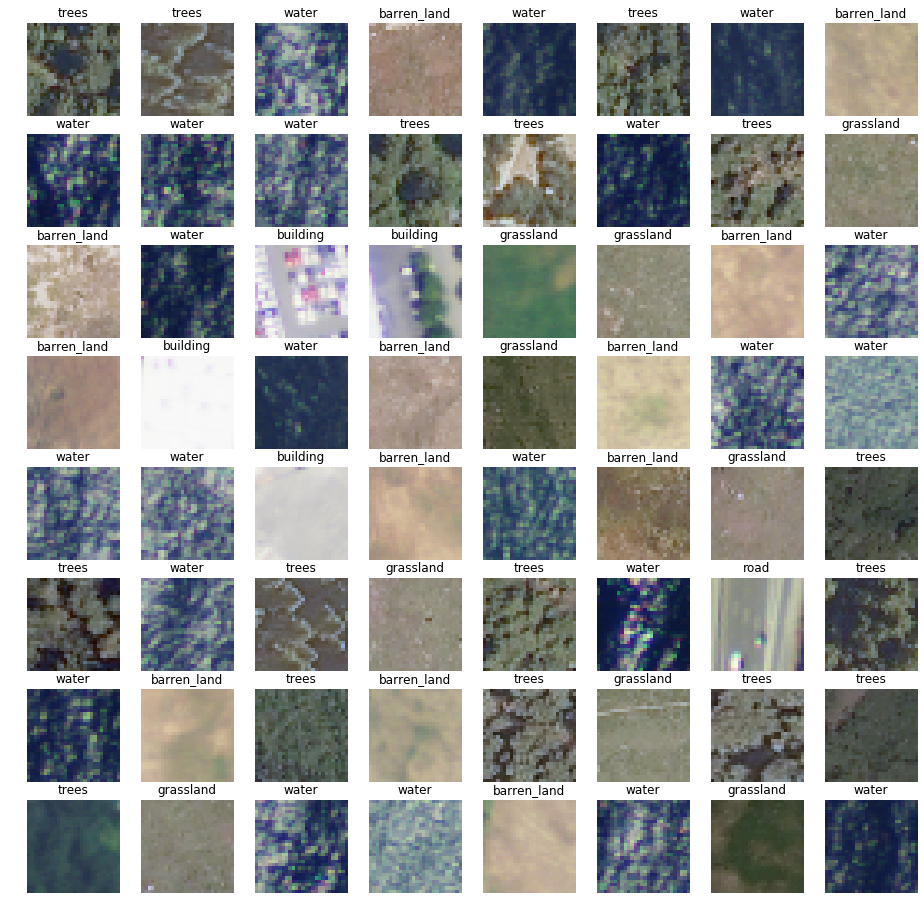

In [0]:
imgs, labels = next(test_gen)
plot_images(imgs, labels)

## The model

Now we will define the model that we will then train on our dataset.

First we import keras and some useful modules like the layers and the callbacks.

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow among others. For more details see [here](https://keras.io/).

In [0]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, SpatialDropout2D
from keras.callbacks import ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


### Model architecture
In the next cell we define the model.
Our model has 4 layers:
- a convolution layer that takes a 28x28x4 tensor as input and applies 16 filters of size 5x5 (with strides 2x2 and relu nonlinearity on top of it)
- a second convolution layer that applies 32 3x3 filters on the output of the previous layer
- a layer to flatten the 3D tensor of the previous layer
- a Fully connected layer with 6 outptus. Each output corresponds to one possible label/class. The outputs are in the range [0, 1] and their sum is 1 (similar to probabilities).

### Model complilation
After defining the architecture of the model, we compile it. In order to compile it we need to define the follow:
- optimizer: the method that the algorithm will use in order to optimize the model's weights during the training [here](https://keras.io/optimizers/)).
- loss: a function that we want to minimize. It depicts the difference between the model's predictions and the real annotations. *Categorical crossentropy* is a popular loss function when dealing with classification problems (for more details see [here](https://keras.io/losses/)).
- metrics (optional): metrics based on which we evaluate the performance of the model. Such metrics can be accuracy, sensitivity, specificity, mean absolute error etc. (for more details see [here](https://keras.io/metrics/)).

### Callbacks
Callbacks are functions to be applied at given stages of the training procedure. In our case we will define *checkpointer* a predefined callback that saves (the best) state(s) of the model during training. This way we can the load and use the best model's state based on our selected criteria. In our case it is the validation accuracy (for more details see [here](https://keras.io/callbacks/)).

In [0]:
K.clear_session()

model = Sequential((
    Conv2D(16, 5, strides=2, activation='relu', input_shape=IMG_SHAPE),
    Conv2D(32, 3, strides=2, activation='relu'),
    Flatten(),
    Dense(len(label_names), activation='softmax')
))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

checkpointer = ModelCheckpoint(filepath='model.hdf5', monitor='val_acc',
                               save_best_only=True)
# model.summary()

Instructions for updating:
Colocations handled automatically by placer.


For the moment the weights of the model are randomly initialized which means that the predictions of the model will be random.

In the next cell we can see some sample of images. For each image we have the real labe/predicted label pair.

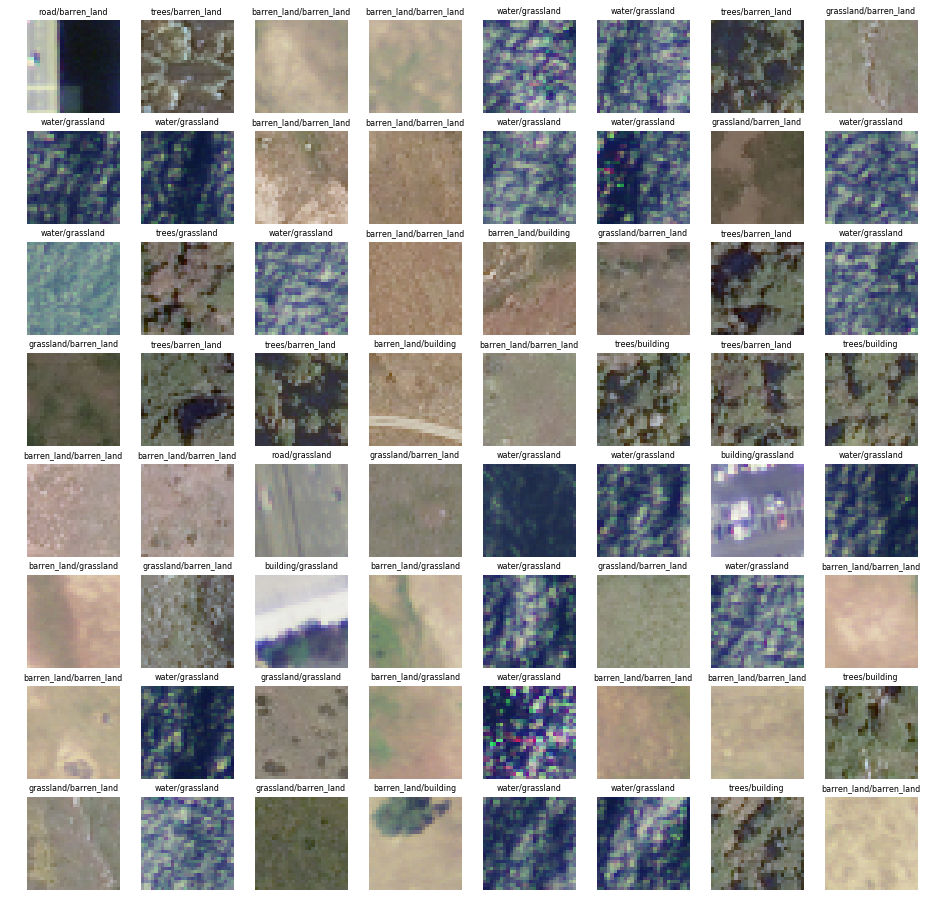

In [0]:
imgs, labels = next(test_gen)
preds = model.predict_on_batch(imgs)
plot_images(imgs, labels, preds)

### Model training
In the next cell we will train the model.

We initialize the generators and the we call the fit_generator() method of the model. This will run for 10 epochs and train the model on batches of 64 images.

After each epoch we get the validation of the model on the test set.

At the last line of the cell we load to the variable *model* the best model in terms of accuracy as it was saved by the *checkpointer* callback.

*(training at colab takes a bit more than an hour for 10 epochs)*

In [0]:
train_gen = get_gen('X_train_sat6.csv', 'y_train_sat6.csv', augment=True)
test_gen = get_gen('X_test_sat6.csv', 'y_test_sat6.csv')

model.fit_generator(train_gen, steps_per_epoch=train_steps,
                    validation_data=test_gen, validation_steps=test_steps,
                    epochs=EPOCHS, callbacks=[checkpointer])

model = load_model('model.hdf5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
5062/5062 [==============================] - 404s 80ms/step - loss: 0.1605 - acc: 0.9358 - val_loss: 0.0851 - val_acc: 0.9681
Epoch 2/10
5062/5062 [==============================] - 408s 81ms/step - loss: 0.0897 - acc: 0.9664 - val_loss: 0.0727 - val_acc: 0.9735
Epoch 3/10
5062/5062 [==============================] - 410s 81ms/step - loss: 0.0733 - acc: 0.9738 - val_loss: 0.0646 - val_acc: 0.9767
Epoch 4/10
5062/5062 [==============================] - 406s 80ms/step - loss: 0.0667 - acc: 0.9762 - val_loss: 0.0549 - val_acc: 0.9819
Epoch 5/10
5062/5062 [==============================] - 407s 80ms/step - loss: 0.0626 - acc: 0.9780 - val_loss: 0.0607 - val_acc: 0.9788
Epoch 6/10
5062/5062 [==============================] - 407s 80ms/step - loss: 0.0592 - acc: 0.9789 - val_loss: 0.0500 - val_acc: 0.9842
Epoch 7/10
5062/5062 [==============================] - 410s 81ms/step - loss: 0.0564 - acc: 0.9799 - val_loss: 0.0467 - val_acc: 

### Visual inspection of the training resuts
We can obtain the performance of the trained model by running the same code as before. This time we can see that the predicted labels almost always agree with the real ones. The model is trained!

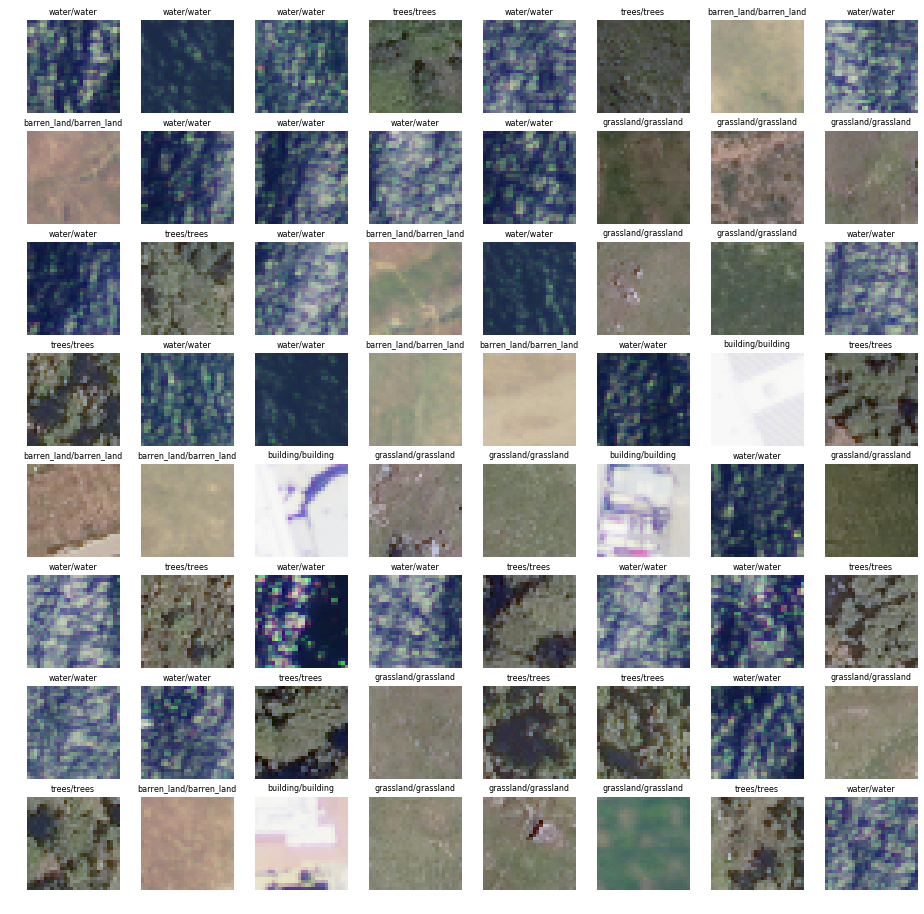

In [0]:
imgs, labels = next(test_gen)
preds = model.predict_on_batch(imgs)
plot_images(imgs, labels, preds)

### Evaluate and download the model
We can also evaluate the model and get its accuracy on the test set

In [0]:
test_gen = get_gen('X_test_sat6.csv', 'y_test_sat6.csv')

evaluation = model.evaluate_generator(test_gen, steps=test_steps)
print('accuracy: %.2f%%' % (evaluation[1]*100))

accuracy: 98.59%


Finally, we can also download the best model in case we want to use it for inference on another device.

In [0]:
from google.colab import files
files.download('model.hdf5') 

## Summary

In this notebook we dealt with the DeepSat kaggle dataset. Specifically we saw how to:

- download the dataset using the kaggle API
- read big .csv files line by line without the need to load them to the memory
- write simple generator functions to yield batches of data
- preprocess and augment images
- build a simple Convolutional Neural Network
- train the network for some epochs and save the one with the best accuracy
- visually check the results of the trained model
- evaluate the model and dowload it (in case we used colab)

## The end